In [1]:
# INSTALLATION OF PACKAGES

import pandas as pd                 # Data manipulation and analysis
import matplotlib.pyplot as plt     # Plotting and visualization
import seaborn as sns               # Statistical data visualization
import numpy as np                  # Numerical operations
import geopandas as gpd             # Geospatial data manipulation
import ipywidgets as widgets        # Interactive widgets for Jupyter notebooks

import os                           # Operating system interfaces
import requests                     # HTTP library for making requests
import warnings                     # Warning control

Se descarga la base de datos y se guarda en una carpeta llamada Datos

In [2]:
# URL of the database
file_download_link = "https://drive.usercontent.google.com/download?id=14cr_NcbnRlxGBAE2KwluXO5RWcV7h27a&export=download&authuser=0&confirm=t&uuid=ab338839-bb46-415c-9e0b-baa349f66125&at=ALWLOp58TXtgKEDFavl5Kn2Hru6H:1762816912784"

# Folder creation and path definition
folder_name = "Datos"
file_name = "RBDSimce4toBasico2014-2024.xlsx"

# Create the folder if it does not exist
os.makedirs(folder_name, exist_ok=True)
file_path = os.path.join(folder_name, file_name) # Full file path

# Download and save the file
response = requests.get(file_download_link)
with open(file_path, 'wb') as f:
    f.write(response.content)

print(f"File downloaded successfully at: {file_path}")

File downloaded successfully at: Datos/RBDSimce4toBasico2014-2024.xlsx


al cargar los datos, se ignoran las advertencias ya que algunas celdas pueden tener formatos inconsistentes
provocando advertencias que no afectan el análisis de los datos.

In [2]:
#load data from the SIMCE 4th grade results from 2014 to 2024

warnings.simplefilter("ignore")

#loads data 
df_simce_2014 = pd.read_excel('Datos/RBDSimce4toBasico2014-2024.xlsx', sheet_name='2014')
df_simce_2015 = pd.read_excel('Datos/RBDSimce4toBasico2014-2024.xlsx', sheet_name='2015')
df_simce_2016 = pd.read_excel('Datos/RBDSimce4toBasico2014-2024.xlsx', sheet_name='2016')
df_simce_2017 = pd.read_excel('Datos/RBDSimce4toBasico2014-2024.xlsx', sheet_name='2017')
df_simce_2018 = pd.read_excel('Datos/RBDSimce4toBasico2014-2024.xlsx', sheet_name='2018')
df_simce_2022 = pd.read_excel('Datos/RBDSimce4toBasico2014-2024.xlsx', sheet_name='2022')
df_simce_2023 = pd.read_excel('Datos/RBDSimce4toBasico2014-2024.xlsx', sheet_name='2023') 
df_simce_2024 = pd.read_excel('Datos/RBDSimce4toBasico2014-2024.xlsx', sheet_name='2024') 

print("Data loaded successfully.")

Data loaded successfully.


Se unifica los DataFrames anuales en un único conjunto consolidado (`df_simce_all_years`). Dado que las columnas pueden variar entre años (nuevas métricas o cambios de metodología), el código realiza una **normalización de esquema** automática.

In [3]:
# Primero se organizan los datos en un diccionario
dfs_dict = {
    '2014': df_simce_2014, '2015': df_simce_2015, '2016': df_simce_2016, 
    '2017': df_simce_2017, '2018': df_simce_2018, '2022': df_simce_2022, 
    '2023': df_simce_2023, '2024': df_simce_2024
}

# Se calculan las columnas comunes
common_columns = set.intersection(*[set(df.columns) for df in dfs_dict.values()])
print(f'Number of common columns: {len(common_columns)}')


# Se verifica si todas las dataframes tienen las mismas columnas y se concatenan para crear un solo dataframe
columns_match = all(len(df.columns) == len(common_columns) for df in dfs_dict.values())


if columns_match: # si todas las columnas coinciden, se concatenan directamente
    df_simce_all_years = pd.concat(dfs_dict.values(), ignore_index=True)
    print('\n Filtered and merged dataframes successfully.')
    
else:  # si no coinciden, se informa de las diferencias y se filtran antes de concatenar
    for year, df in dfs_dict.items():
        diff = set(df.columns) - common_columns
        if diff:
            print(f'Columns in {year} not in common: {diff}')
    df_simce_all_years = pd.concat([df[list(common_columns)] for df in dfs_dict.values()], ignore_index=True)
    print('\n Filtered and merged dataframes successfully.')

Number of common columns: 38
Columns in 2014 not in common: {'siggru_soc4b_rbd', 'nalu_soc4b_rbd', 'nom_deprov_rbd', 'nom_reg_rbd_2014', 'marcadif_soc4b_rbd', 'cod_com_rbd_2014', 'palu_eda_ins_soc4b_rbd', 'palu_eda_ele_soc4b_rbd', 'prom_soc4b_rbd', 'codigo_bbdd', 'sigdif_soc4b_rbd', 'fecha_bbdd', 'marca_eda_mate4b_rbd', 'dif_soc4b_rbd', 'cod_reg_rbd_2014', 'nom_pro_rbd_2014', 'marca_soc4b_rbd', 'nom_deprov_rbd_2014', 'nom_com_rbd_2014', 'difgru_soc4b_rbd', 'cod_pro_rbd_2014', 'marca_eda_lect4b_rbd', 'marca_eda_soc4b_rbd', 'palu_eda_ade_soc4b_rbd'}
Columns in 2015 not in common: {'codigo_bbdd', 'fecha_bbdd', 'cod_deprov_rbd', 'nom_deprov_rbd'}
Columns in 2016 not in common: {'codigo_bbdd', 'fecha_bbdd', 'nom_deprov_rbd'}
Columns in 2018 not in common: {'codigo_bbdd', 'fecha_bbdd', 'cod_deprov_rbd', 'nom_deprov_rbd'}
Columns in 2022 not in common: {'codigo_bbdd', 'fecha_bbdd', 'cod_deprov_rbd', 'nom_deprov_rbd'}
Columns in 2023 not in common: {'codigo_bbdd', 'fecha_bbdd', 'cod_deprov_rbd

In [4]:
df_simce_all_years.describe()

,dvrbd,difgru_lect4b_rbd,rbd,dif_lect4b_rbd,palu_eda_ade_mate4b_rbd,agno,cod_reg_rbd,dif_mate4b_rbd,nalu_lect4b_rbd,palu_eda_ele_mate4b_rbd,palu_eda_ele_lect4b_rbd,prom_mate4b_rbd,cod_com_rbd,palu_eda_ins_lect4b_rbd,palu_eda_ade_lect4b_rbd,palu_eda_ins_mate4b_rbd,prom_lect4b_rbd,nalu_mate4b_rbd,difgru_mate4b_rbd,cod_pro_rbd
count,59189.000000,49416.000000,59189.000000,48101.000000,44360.000000,59189.000000,59189.000000,48119.000000,58487.000000,44360.000000,44328.000000,54820.000000,59189.000000,44328.000000,44328.000000,44360.000000,54856.000000,58487.000000,49428.000000,59189.000000
mean,4.480647,-1.196596,9610.434152,1.556392,18.854612,2018.543513,9.005643,0.982647,29.274163,34.287193,26.191565,244.972601,6924.199294,29.960959,34.798946,37.881506,258.037571,29.451451,-1.899672,47.044518
std,2.881179,18.574622,8201.773237,19.208006,17.755270,3.594657,3.611760,19.037830,30.130788,15.888895,12.511650,44.664989,5106.261046,19.483667,20.736994,23.871446,44.608976,30.342481,20.248251,52.677725
min,0.000000,-133.000000,5.000000,-118.000000,0.000000,2014.000000,1.000000,-118.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-141.000000,1.000000
25%,2.000000,-12.000000,3448.000000,-9.000000,5.600000,2015.000000,6.000000,-9.000000,6.000000,26.500000,20.000000,230.000000,48.000000,15.400000,20.500000,19.000000,245.000000,6.000000,-14.000000,1.000000
50%,4.000000,0.000000,7496.000000,0.000000,14.300000,2017.000000,9.000000,0.000000,21.000000,36.800000,27.500000,249.000000,7401.000000,29.000000,34.400000,38.500000,263.000000,21.000000,0.000000,7.000000
75%,7.000000,9.000000,12682.000000,12.000000,27.500000,2022.000000,13.000000,11.000000,40.000000,45.100000,34.000000,268.000000,11101.000000,43.200000,48.700000,55.600000,280.000000,40.000000,10.000000,91.000000
max,9.000000,124.000000,42261.000000,137.000000,100.000000,2024.000000,16.000000,113.000000,284.000000,85.700000,80.000000,376.000000,16305.000000,100.000000,100.000000,100.000000,396.000000,282.000000,108.000000,163.000000


In [5]:
df_simce_all_years.rename(columns={'nom_reg_rbd': 'Region', 'nom_com_rbd': 'Comuna', 'prom_lect4b_rbd': 'Avg Reading Score', 'prom_mate4b_rbd': 'Avg Math Score'}, inplace=True)
df_simce_all_years['Region']

0        REGIÓN ARICA - PARINACOTA
1        REGIÓN ARICA - PARINACOTA
2        REGIÓN ARICA - PARINACOTA
3        REGIÓN ARICA - PARINACOTA
4        REGIÓN ARICA - PARINACOTA
                   ...            
59184              DE LA ARAUCANÍA
59185                   DEL BIOBÍO
59186                   DEL BIOBÍO
59187    DEL LIBERTADOR BERNARDO O
59188    DEL LIBERTADOR BERNARDO O
Name: Region, Length: 59189, dtype: object

Number of cities found in Región Metropolitana de Santiago: 52


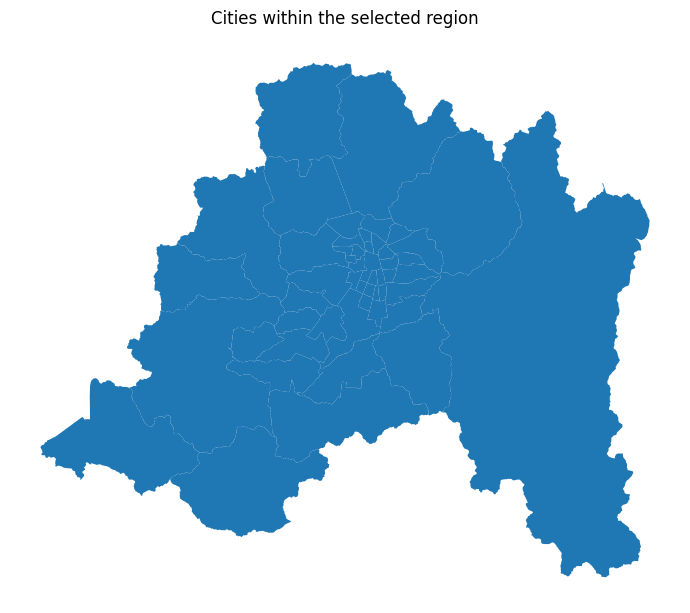

In [6]:
#gdf_regions = gpd.read_file('Regional.shp',encoding='utf-8')
gdf_cities = gpd.read_file('comunas.shp', encoding='utf-8')

# Example workflow to select a specific region and its cities from shapefiles

# --- 1) Select the region you want (by code or name) ---
# Example: by code
target_name = "Región Metropolitana de Santiago"  # Región Metropolitana de Santiago, adjust to yours
#region = gdf_regions.loc[gdf_regions["Region"] == target_name].copy()

# --- 2) Filter cities that lie inside the selected region ---
#Based on the name of the Region column in the cities shapefile
cities_in_region = gdf_cities[gdf_cities['Region'] == target_name]

# --- 3) Plot the region and its cities; zoom to the region extent ---
fig, ax = plt.subplots(figsize=(7, 7))
#region.plot(ax=ax, color="#e8eff7", edgecolor="black", linewidth=1)
cities_in_region.plot(ax=ax, markersize=15)
#print how many cities were found in the region
print(f'Number of cities found in {target_name}: {len(cities_in_region)}')

# Zoom to region with a small padding
#minx, miny, maxx, maxy = region.total_bounds
#pad_x = (maxx - minx) * 0.05
#pad_y = (maxy - miny) * 0.05
#ax.set_xlim(minx - pad_x, maxx + pad_x)
#ax.set_ylim(miny - pad_y, maxy + pad_y)

#addd the title
ax.set_axis_off()
ax.set_title("Cities within the selected region", pad=10)
plt.tight_layout()
plt.show()

In [7]:
selector = widgets.Dropdown(
    options={
        "Lectura 4º Básico": "Avg Reading Score",
        "Matemática 4º Básico": "Avg Math Score",
    },
    value="Avg Reading Score",
    description="Asignatura:"
)

In [8]:
def plot_mapa(columna):
    fig, ax = plt.subplots(figsize=(12, 12))
    cities_in_region.plot(
        column=columna,
        cmap="viridis",
        linewidth=0.4,
        #edgecolor="black",
        legend=True,
        ax=ax
    )
    ax.set_title(f"Puntaje SIMCE — {columna}", fontsize=17)
    ax.axis("off")
    plt.show()


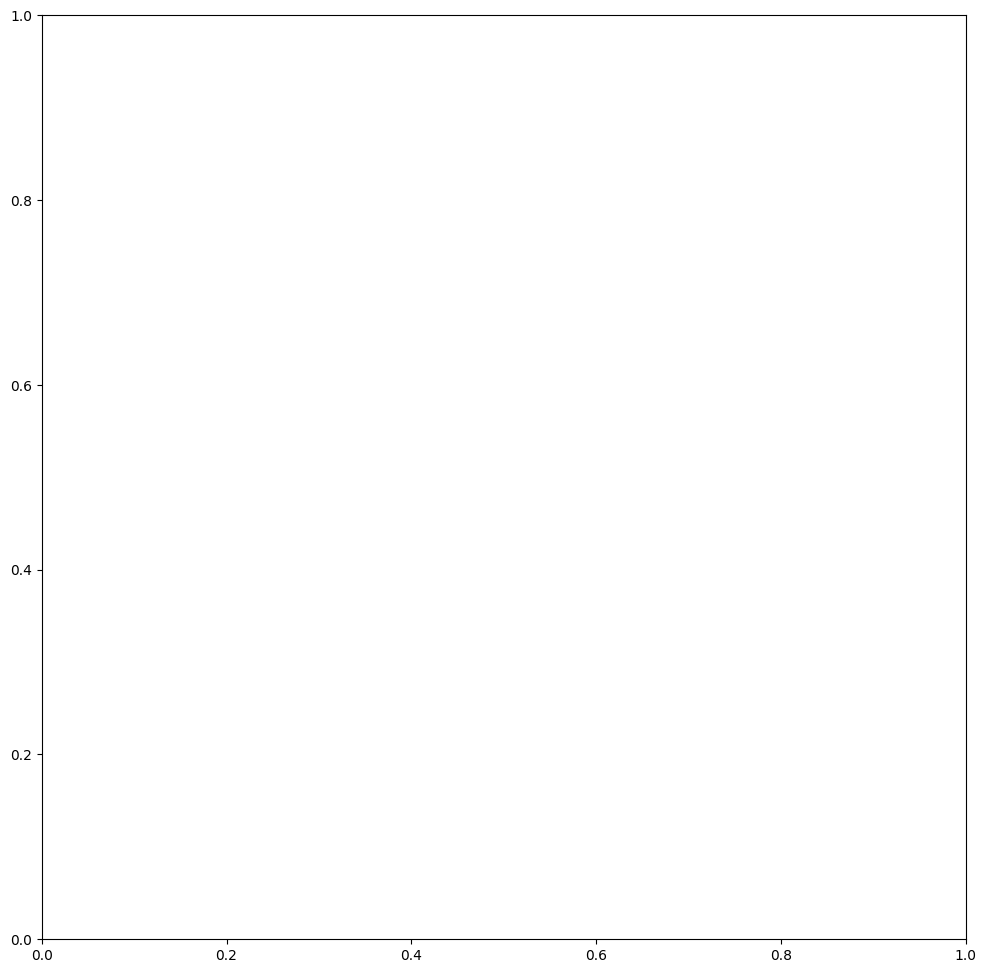

interactive(children=(Dropdown(description='Asignatura:', options={'Lectura 4º Básico': 'Avg Reading Score', '…

<function __main__.plot_mapa(columna)>

In [9]:
widgets.interact(
    plot_mapa,
    columna=selector
)


In [7]:
import re

#get average reading score per city within the 'Región de Los Lagos' for the year 2024
#First, filter the SIMCE data for the year 2024 and the target region
#we need to see if the name of the region in the SIMCE data matches the one in the shapefile, considering accents and capitalization and sometimes different naming conventions

def _normalize_text(s):
	if pd.isna(s):
		return ""
	s = str(s).lower()
	s = s.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u').replace('ñ','n')
	s = re.sub(r'[^a-z0-9\s]', ' ', s)
	s = re.sub(r'\s+', ' ', s).strip()
	return s

# build a normalized core string from the target name (remove generic tokens like 'region', 'de', 'del')
target_norm = _normalize_text(target_name)
target_core = re.sub(r'\b(region|región|de|del|la|el|y)\b', ' ', target_norm)
target_core = re.sub(r'\s+', ' ', target_core).strip()

# normalize the Region column and build mask using .str.contains (works elementwise)
region_norm_series = df_simce_all_years['Region'].astype(str).str.lower() \
	.str.replace('á','a').str.replace('é','e').str.replace('í','i') \
	.str.replace('ó','o').str.replace('ú','u').str.replace('ñ','n')

mask_region = region_norm_series.str.contains(target_core, na=False)

df_simce_2024_los_lagos = df_simce_all_years[(df_simce_all_years['agno'] == 2024) & mask_region].copy()

#The name of the column 'Comuna' is sometimes trimmed so let's replace it with the full name from the shapefile
#We need to find, for each Comuna value within df_simce_2024_los_lagos, the best matching Comuna name from gdf_cities within the target region
comuna_names_shapefile = gdf_cities[gdf_cities['Region'] == target_name]['Comuna'].unique()
def find_best_matching_comuna(comuna_simce, comuna_names_shapefile):
    comuna_simce_norm = _normalize_text(comuna_simce)
    best_match = None
    highest_ratio = 0.0
    for comuna_shapefile in comuna_names_shapefile:
        comuna_shapefile_norm = _normalize_text(comuna_shapefile)
        #calculate simple similarity ratio based on if comuna_since_norm is in comuna_shapefile_norm
        if comuna_simce_norm in comuna_shapefile_norm:
            ratio = len(comuna_simce_norm) / len(comuna_shapefile_norm)
        else:
            ratio = 0.0
        if ratio > highest_ratio:
            highest_ratio = ratio
            best_match = comuna_shapefile
    #Print original vs best match and ratio for debugging
    #print(f'Original: {comuna_simce} | Best Match: {best_match} | Ratio: {highest_ratio:.2f}')
    return best_match if highest_ratio > 0.0 else comuna_simce  #return original if no good match found
df_simce_2024_los_lagos['Comuna'] = df_simce_2024_los_lagos['Comuna'].apply(lambda x: find_best_matching_comuna(x, comuna_names_shapefile))

#Remove rows with NaN or zero reading scores
df_simce_2024_los_lagos = df_simce_2024_los_lagos[df_simce_2024_los_lagos['Avg Reading Score'].replace(0, np.nan).notna()]

#Then, group by city and calculate the average reading score
avg_reading_scores = df_simce_2024_los_lagos.groupby('Comuna', dropna=False)['Avg Reading Score'].mean().reset_index()
avg_reading_scores

# Remove original 'Comuna' column from avg_reading_scores to avoid duplicate column names in the merged GeoDataFrame
#avg_reading_scores = avg_reading_scores.drop(columns=['Comuna'])

#merge gdf_cities with avg_reading_scores on the normalized city name
gdf_cities_los_lagos = gdf_cities[gdf_cities['Region'] == target_name].copy()
gdf_cities_los_lagos = gdf_cities_los_lagos.merge(avg_reading_scores, on='Comuna', how='left')

gdf_cities_los_lagos


,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry,Avg Reading Score
0,330,13987.326781,10,7,13129,13,1.424341e+07,16812.167615,Región Metropolitana de Santiago,San Joaquín,Santiago,"POLYGON ((-7861762.687 -3958307.095, -7861708....",NaN
1,331,13311.641304,13,7,13130,13,1.389538e+07,15988.816037,Región Metropolitana de Santiago,San Miguel,Santiago,"POLYGON ((-7863229.775 -3964360.652, -7863319....",NaN
2,332,11733.486710,13,7,13131,13,9.056280e+06,14061.528858,Región Metropolitana de Santiago,San Ramón,Santiago,"POLYGON ((-7863398.118 -3964354.273, -7863319....",NaN
3,309,11488.695747,9,7,13108,13,1.068637e+07,14088.417488,Región Metropolitana de Santiago,Independencia,Santiago,"POLYGON ((-7865631.125 -3948404.075, -7865643....",NaN
4,310,12797.595762,13,7,13109,13,1.454185e+07,15442.412755,Región Metropolitana de Santiago,La Cisterna,Santiago,"POLYGON ((-7865040.615 -3968217.521, -7865077....",NaN
5,323,36618.971695,11,7,13122,13,7.709271e+07,43954.336968,Región Metropolitana de Santiago,Peñalolén,Santiago,"POLYGON ((-7852667.025 -3963533.211, -7852700....",NaN
6,324,16072.408276,10,7,13123,13,2.073083e+07,19223.740933,Región Metropolitana de Santiago,Providencia,Santiago,"POLYGON ((-7857468.292 -3952687.257, -7857424....",NaN
7,314,23724.899355,11,7,13113,13,3.361510e+07,28343.661508,Región Metropolitana de Santiago,La Reina,Santiago,"POLYGON ((-7852374.608 -3952376.018, -7852375....",NaN
8,295,44852.016431,14,7,13403,13,1.056188e+08,54017.559247,Región Metropolitana de Santiago,Calera de Tango,Maipo,"POLYGON ((-7877355.549 -3971828.617, -7877326....",NaN
9,288,172581.447530,8,7,13301,13,1.386968e+09,206660.187466,Región Metropolitana de Santiago,Colina,Chacabuco,"POLYGON ((-7879353.625 -3919889.834, -7879390....",NaN


NameError: name 'region' is not defined

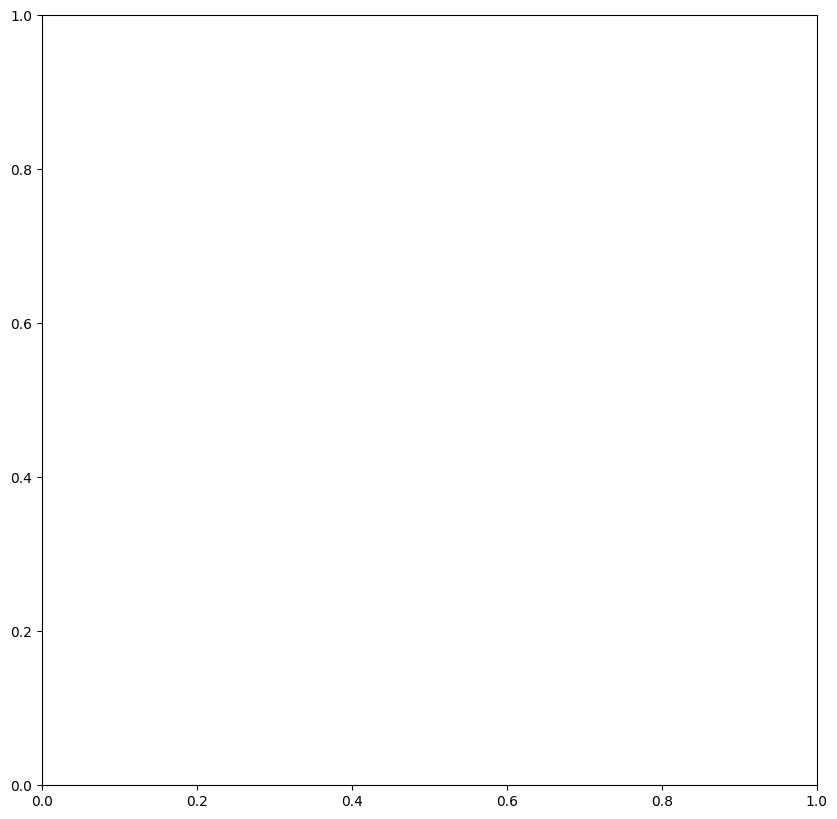

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
region.plot(ax=ax, color="#e8eff7", edgecolor="black", linewidth=1)
gdf_cities_los_lagos.plot(
    ax=ax,
    column='Avg Reading Score',
    cmap='viridis',
    markersize=50,
    legend=True,
    legend_kwds={'label': "Average Reading Score (4th Grade, 2024)", 'shrink': 0.5}
)